In [1]:
from LibraryENGcopia import *
from tqdm import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3

In [2]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
data = h5py.File(complete_string3,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(5875000, 60)


In [3]:
inizio=0
len_data=810000 #192 secondi
#len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(810000,) (810000,)


In [4]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(810000, 1)

In [5]:
pos, neg=find_all_spikes(prova)

809710it [00:06, 118990.62it/s]                                                 

detected spikes: 3604 firing rate:  44.49382716049383


In [6]:
pos_cut,pos, neg_cut,neg = cut(pos,neg,prova)

IndexError: pop index out of range

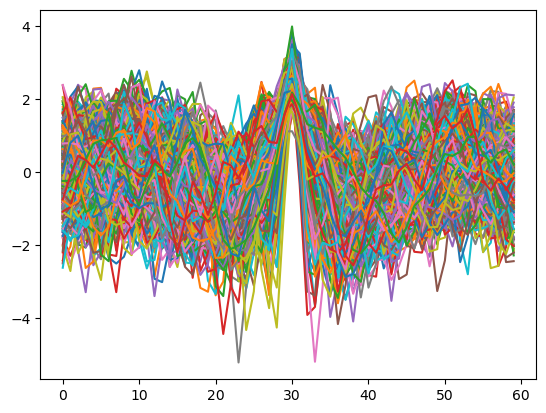

In [13]:
plt.plot(pos_cut.transpose())

In [18]:
from fastdtw import fastdtw
spike1=pos_cut[28]
spike2=pos_cut[379]
distance, path = fastdtw(spike1, spike2)

print(f"DTW distance between spike {i+1} and spike {j+1}: {distance}")
print(f"Alignment path: {path}")

ModuleNotFoundError: No module named 'fastdtw'

379


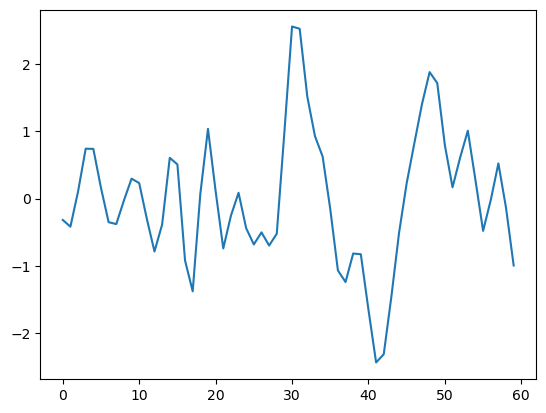

In [16]:
from random import randint
x=randint(1,len(pos_cut))
print(x)

plt.plot(pos_cut[x])